## Power balanced projection methods for time-continuous dynamic simulations

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import rpm_module as rpm
import PH_models as model
#Direct input 
plt.rcParams['text.latex.preamble']= r"\usepackage{color}"
#Options
params = {'text.usetex' : True,
          'font.size' : 18,
          'font.family' : 'lmodern',
          'ps.usedistiller' : 'xpdf'
          }
plt.rcParams.update(params) 


## Basis of the projection and approximation spaces

We use a shifted Legendre polynomials basis as the RPM basis. The basis $\Psi_P$ of the projection step is built by taking the first $p$ shifted Legendre polynomials : 
$$\Psi_P = \{\tilde{L}_i\}^{p-1}_{i=0}.$$


Text(0.5, 1.0, 'Basis functions $\\Psi_P$ of the projection step')

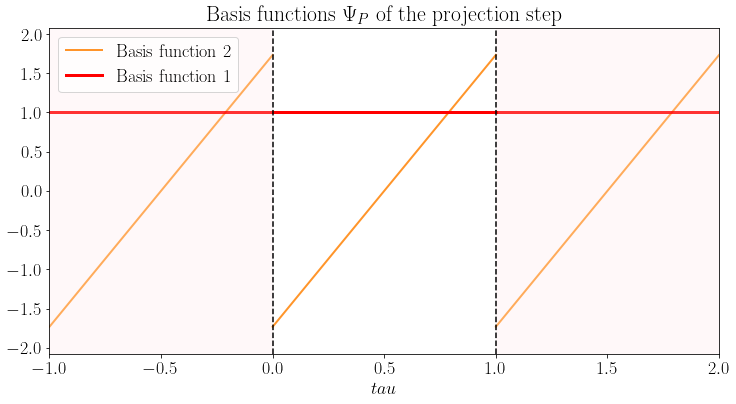

In [2]:
# Some PHS model (here, an LC circuit)
phs_struct = model.muller.build_non_linear(1, 1, 1)

# Solver parameters
p_order = 2
k_order  = 2
sr = 0.5
stepSize = 1/sr

rpmsolver = rpm.RPMSolverPHS(phs_struct, p_order, k_order, stepSize, quad_order=100)

fig = rpm.hp.plot_basis_P(rpmsolver)
plt.title(r"Basis functions $\Psi_P$ of the projection step")

The basis $\Psi_R$ of the regularization step is built from the Legendre polynomials $\Psi_{L_R}=\{\tilde{L}_i\}^{p+2k-1}_{i=p}$ such that the application of the multi-derivative boundary operator $\mathcal{B}$ to the basis $\Psi_R$ yields the identity matrix: 
$$\mathcal{B}({\Psi_R}) = \mathbf{I}_{2k,2k}$$
To build this basis we compute the transition matrix $\mathbf{M}$ such that : 
\begin{equation}
    \Psi_R = \mathbf{M}\Psi_{L_R} \overset{\mathcal{B}}{\Rightarrow} \mathbf{I}_{2k,2k} = \mathcal{B}(M\Psi{L_R})\Rightarrow \mathbf{M} = (\mathcal{B}(\Psi_{L_R}))^{-1}. 
\end{equation}

Text(0.5, 1.0, 'Basis functions $\\Psi_R$ of the regularization step')

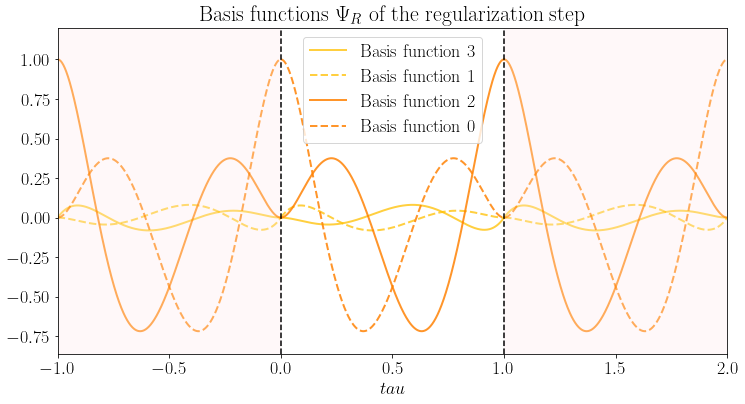

In [3]:
fig = rpm.hp.plot_basis_R(rpmsolver)
plt.title(r"Basis functions $\Psi_R$ of the regularization step")

## Numerical integration : Gauss-Legendre quadrature

Here, we test the quadrature integration procedure and try to obtain the same results as the one page 145 of Remy Muller's thesis. 

1 - Results for $f(x) = e^{ax}-1$ with $a=3$.

In [4]:
alpha = 3
x0 = -1
x1 = 1

#Creation of function f(x(t))
def g(t, x0, x1):
    return x0 + t*(x1-x0)

def f(x, alpha):
    return np.exp(alpha*x) - 1

def fg(t, alpha, x0 = -1, x1 = 1):
    return f(g(t, x0, x1), alpha)

#Function to compute the theoretical integral value
def analyticIntegration(alpha, x0, x1):
    return (np.exp(alpha*x1) - np.exp(alpha*x0)) / (alpha*(x1-x0)) -1

fgToPass = lambda t : fg(t, alpha, x0, x1)

approxError = rpmsolver.quad.quadrature_convergence(fgToPass, analyticIntegration(alpha, x0, x1), 100)

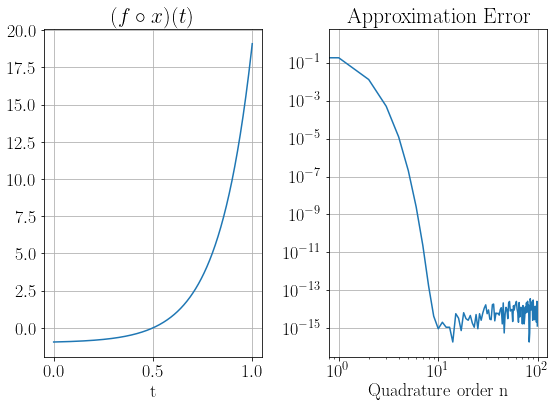

In [5]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.grid(True)
x = np.linspace(0,1,500)
plt.plot(x, fgToPass(x))
plt.xlabel('t')
plt.title('$(f \circ x)(t)$')

plt.subplot(1,3,2)
plt.grid(True)
plt.loglog(approxError)
plt.xlabel('Quadrature order n')
plt.title('Approximation Error')
plt.tight_layout()

2 - Results for $f(x) = max(ax,0)$ and $a = 3$.

In [6]:
alpha = 3
x0 = -1
x1 = 1

#Creation of function f(x(t))
def g(t, x0, x1):
    return x0 + t*(x1-x0)

def f(x, alpha):
    return (x>0)*x*alpha

def fg(t, alpha, x0 = -1, x1 = 1):
    return f(g(t, x0, x1), alpha)

#Function to compute the theoretical integral value
def analyticIntegration(alpha, x0, x1):
    return alpha*(x1/2 - (x1-x0)/8)

fgToPass = lambda t : fg(t, alpha, x0, x1)

approxError = rpmsolver.quad.quadrature_convergence(fgToPass, analyticIntegration(alpha, x0, x1), 100)

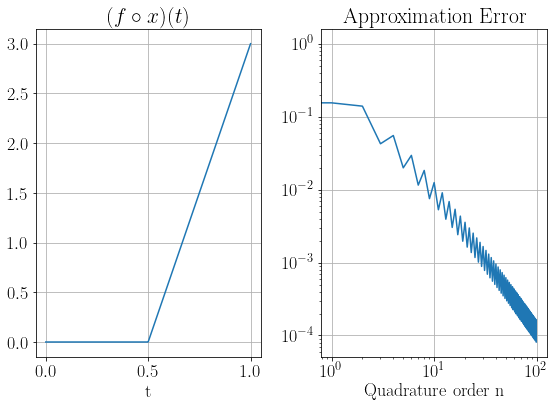

In [7]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.grid(True)
x = np.linspace(0,1,500)
plt.plot(x, fgToPass(x))
plt.xlabel('t')
plt.title('$(f \circ x)(t)$')

plt.subplot(1,3,2)
plt.grid(True)
plt.loglog(approxError)
plt.xlabel('Quadrature order n')
plt.title('Approximation Error')
plt.tight_layout()

We observe a good convergence of the integration error with the quadrature order, as expected.

## Simulation of autonomous conservative systems

The implemented solver only supports regularization of the states up to order 2. The extension to the regularization of outputs also is easy while adding regularization of the dissipations variables is more complex.

In [8]:
# Non linear autonomous LC circuit
phs_struct = model.muller.build_non_linear(1, 1, 1)
#Solver parameters
p_order = 1
k_order  = 1
sr = 1
stepSize = 1/sr
quadOrder = 100
epsilon = 10**(-15)
maxIter = 100

solver = rpm.RPMSolverPHS(phs_struct, p_order, k_order, stepSize,
    quadOrder, epsilon, maxIter)

init = np.zeros(len(phs_struct["States"]), dtype= np.float64)
init[1] = 2
duration = 100
t = np.linspace(0, duration, int(duration/stepSize))
x, dx_proj, l_mults, dx_regul = solver.simulate(init, duration)

Mean number of NR iterations : 3.8979591836734695
Max number of NR iterations : 4.0,              step index : 0


We first present the results of the simulation of a non-linear LC circuit with $p=1$, $k=1$.

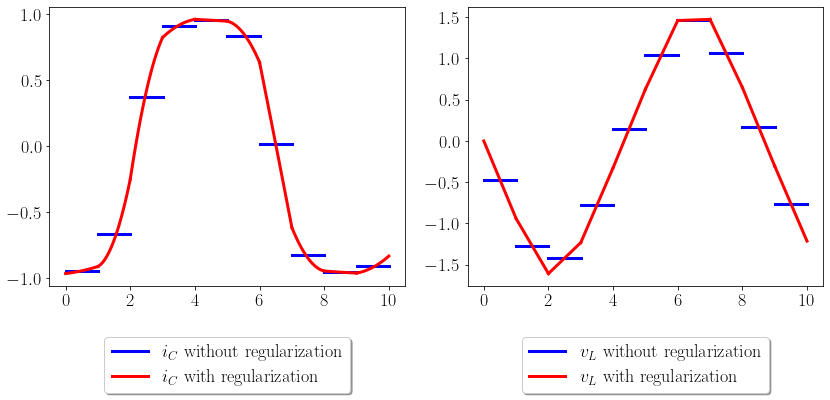

In [9]:
fig = rpm.hp.plot_flows_trajectories(solver, dx_proj[:10], dx_regul[:10], labels = ["$i_C$", "$v_L$"],N_points=50)
#plt.savefig('rpm_method.png', dpi=300)

The following figure presents the results corresponding to different values of $p$ and $k$. The simulation upsampled by a factor 200 is plotted as reference.

In [12]:
p_orders = [1, 2, 3]
k_orders = [0, 1, 2]

sr = 50
stepSize = 1/sr
quadOrder = 100
epsilon = 10**(-15)
maxIter = 100
init = np.zeros(len(phs_struct["States"]), dtype= np.float64)
init[1] = 1
duration = 100
t = np.linspace(0, duration, int(duration/stepSize))

solver = rpm.RPMSolverPHS(phs_struct, 1, 1, stepSize,
            quadOrder, epsilon, maxIter)
   
x, dx_truth, l_mults, dx_regul = solver.simulate(init, duration)


Mean number of NR iterations : 2.0004001600640255
Max number of NR iterations : 3.0,              step index : 426


Mean number of NR iterations : 6.043478260869565
Max number of NR iterations : 9.0,              step index : 13
Mean number of NR iterations : 6.043478260869565
Max number of NR iterations : 9.0,              step index : 13
Mean number of NR iterations : 6.043478260869565
Max number of NR iterations : 9.0,              step index : 13
Mean number of NR iterations : 5.739130434782608
Max number of NR iterations : 6.0,              step index : 0
Mean number of NR iterations : 5.739130434782608
Max number of NR iterations : 6.0,              step index : 0
Mean number of NR iterations : 5.739130434782608
Max number of NR iterations : 6.0,              step index : 0
Mean number of NR iterations : 5.565217391304348
Max number of NR iterations : 6.0,              step index : 1
Mean number of NR iterations : 5.565217391304348
Max number of NR iterations : 6.0,              step index : 1
Mean number of NR iterations : 5.565217391304348
Max number of NR iterations : 6.0,              step

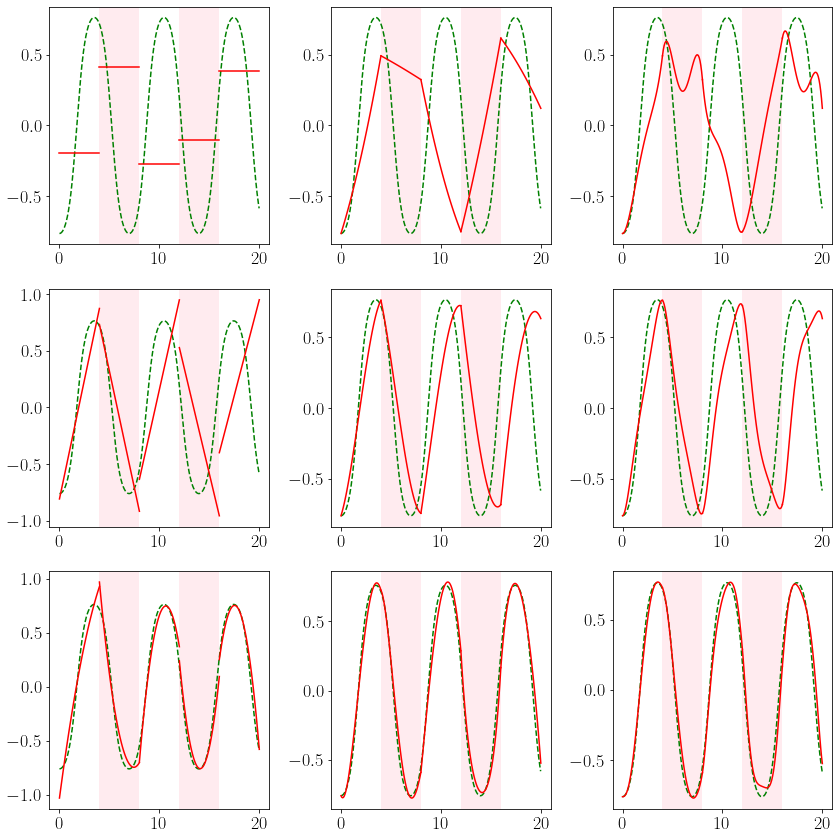

In [13]:

fig, axs = plt.subplots(len(p_orders), len(k_orders), figsize=(12, 12))
N = 50
tau = np.linspace(0, 1, N)

sr = 0.25
stepSize = 1/sr
for p in p_orders:
    for k in k_orders:
        #Solver parameters
        p_order = p
        if k==0:
            k_order  = 1
        else:
            k_order = k
        solver = rpm.RPMSolverPHS(phs_struct, p_order, k_order, stepSize,
            quadOrder, epsilon, maxIter)

        x, dx_proj, l_mults, dx_regul = solver.simulate(init, duration)
        axs[p-1, k].plot(t[:1000], dx_truth[:1000, 0, 0], color='green', linestyle='--')
        if k!=0:
            results = rpm.hp.compute_flows_trajectories(solver, dx_proj[:5], dx_regul[:5], N_points=N, regul=True)[:, 0, :]
            for step in range(len(results)):
                axs[p-1, k].plot((step+tau)*stepSize, results[step], c='r')
                if step%2 != 0:
                    axs[p-1, k].axvspan(step*stepSize, (step+1)*stepSize, facecolor='pink', alpha=0.3)
        else:
            results = rpm.hp.compute_flows_trajectories(solver, dx_proj[:5], dx_regul[:5], N_points=N, regul=False)[:, 0, :]
            for step in range(len(results)):
                axs[p-1, k].plot((step+tau)*stepSize, results[step], c='r')
                if step%2 != 0:
                    axs[p-1, k].axvspan(step*stepSize, (step+1)*stepSize, facecolor='pink', alpha=0.3)
        #axs[p-1, k].set_xlabel('Temps (s)')
        #axs[p-1, k].set_ylabel(r'$I_c$')
plt.tight_layout()